Es gibt unterschiedliche Schreibweisen (Namenskonvention) für Variablen in Software-Code. Im Folgenden wird CapWords verwendet (von CapitalizedWords auch CamelCase oder Medial Capitals genannt). Der Variabelname wir mit Kleinbuchstaben geschrieben und der Beginn der Wörter wird gross und zusammen geschrieben. Beginnender Buchstabe ist klein. Als Beispiel eine Variabel aus drei Informationen:

h für Strahlung

Glob für Globalstrahlung

Buchs für den Standort Buchs

So wird die Variabel mit CapWord als „hGlobBuchs“ beschrieben. Eine andere Namenskonvention wäre Snake_Case, als Beispiel: „h_glob_buchs“.

Im Tutorial werden folgende Variablennamen verwendet:

$\Phi_w$ = lg (gibt den Längengrad des Standorts in Grad an)

$\rho$ = bg (gibt den Breitengrad des Standorts in Grad an)

$\omega$ = omega (Stundenwinkel in Grad. 0° entspricht 12 Uhr wahrer
Ortszeit)

$\delta$ = dekl (Deklination in Grad)

$h$ = h (gesuchte Grösse Sonnenhöhe h in Grad)

$\Psi$ = azi (gesuchte Grösse Sonnenazimut in Grad)


# Tutorial 1: Berechnung des Sonnenstands
Ausgehend vom Standort und der Zeit in UTC wird die Sonnenhöhe h und der Sonnenazimut $\Psi$ über die folgenden Formeln berechnet, ohne Berücksichtigung der Zeitgleichung:
$$\omega = \phi_w + 15\cdot t_{utc} - 180^{\circ}$$

$$\delta = 23.45 \cos \left(\dfrac{360^{\circ}}{8760} \cdot(n-173 \cdot 24)\right)$$

$$\sin(h) = \sin(\delta) \sin(\rho) + \cos(\delta) \cos(\rho) \cos(\omega)$$

$$\cos(\Psi) = \frac{\sin(h) \sin(\rho) - \sin(\delta)}{\cos(h) \cos(\rho)}$$

Um vom Datum, bestehend aus Monat und Tag, den laufenden Tag n (beginnend vom 1. Jänner) zu berechnen eignet sich folgende Formel, sofern notwendig:

$$nTag=int \left(\dfrac{275\cdot M}{9}\right) - K\cdot int  \left(\dfrac{M+9}{12}\right)+D-30$$

M steht für den Monat, D für den Tag, K = 1 für ein Schaltjahr, K = 2 für ein normales Jahr. int steht für die Verwendung des Integerwerts der Zahl (Python-Funktion int). Die laufende Stunde n im Jahr berechnet sich:

$$n = 24 \cdot nTag + hh$$

Für hh die Stunde. Für die Berechnung der Sonnenhöhe h und des Sonnenazimuts $\Psi$ muss die Umkehrfunktion von $\sin()$ bzw. $\cos()$ verwendet werden. Diese ist allerdings nicht eineindeutig. Die Umkehrfunktion von Sinus (Arcussinus) ist nur für den Bereich $-90^\circ$ bis $90^\circ$ eineindeutig.

![Sinusfuktion im Einheitskreis](sin.png)

D.h. für die Sonnenhöhe h ist die Umkehrfunktion gültig, weil der Wertebereich der Sonnenhöhe zwischen $-90^\circ$ und $90^\circ$ liegt. Die Umkehrfunktion von Kosinus (Arcuskosinus) ist für den Bereich $0^\circ$ bis $180^\circ$ eindeutig.

![Kosinusfuktion im Einheitskreis](cos.png)

Für den Sonnenazimut ist dies nicht eindeutig, da der Sonnenazimut von weniger als $-120^\circ$ bis über $120^\circ$ durchläuft. Für den Verlauf der Sonne von Mittag=Süden ($0^\circ$) bis zum Abend=Westen (über $90^\circ$) liefert die Umkehrfunktion den richtigen Wert. Für den Verlauf von Morgen=Osten (unter $-90^\circ$) bis Mittag=Süden ($0^\circ$) liefert die Umkehrfunktion den richtigen Wert, mit falschem Vorzeichen (plus anstatt minus). Dies soll in der Berechnung berücksichtigt werden. Das Erkennen ob der Azimut korrigiert werden soll, erfolgt durch den Stundenwinkel $\omega$. Ist dieser $>0^\circ$ so steht dies für den Nachmittag und wenn dieser $<0^\circ$, dann steht dies für den Vormittag.

### Hinweis:

Da wir mit laufenden Stunden rechnen, ist am zweiten Tag, im Jahr um 12 h nicht $0^\circ$, sondern $0^\circ$+$360^\circ$. Somit können wir keine Fallunterscheidung Vormittag/Nachmittag über $<0^\circ$ oder $>0^\circ$ durchführen. Aus diesem Grund wird der Stundenwinkel $\omega$ auf den Bereich $-180^\circ$ (=0 h) bis $180^\circ$ (=24 h) zurückgerechnet, d.h. Stunden innerhalb des Tages und nicht laufende Jahresstunden. Dies wird durch die Modulus Funktion (Rest Funktion) durchgeführt, was einen Bereich von $0^\circ$ bis $360^\circ$ ergibt. Durch Verschiebung vorher $+180^\circ$ und nach Modulus Funktion $-180^\circ$ erreichen wird unseren gesuchten Bereich von  $-180^\circ$ bis $180^\circ$.

All dies wird mit nur einer Code-Zeile erreicht!

    omega = np.mod(omega + 180, 360)-180 
   
Wenn dies klar ist, so ist eine Pauser verdient!

In [9]:
### importieren von Bibliotheken
import matplotlib.pyplot as plt
import numpy as np

### definiern von Funktionen mit dem lambda-Operator
cos  = lambda arg : np.cos(np.deg2rad(arg))
sin  = lambda arg : np.sin(np.deg2rad(arg))
acos = lambda arg : np.rad2deg(np.arccos(arg))
asin = lambda arg : np.rad2deg(np.arcsin(arg))

###  Parameterdefinition
lg = 9 + 26/60  # [grad] Längengrad
bg = 46 + 37/60 # [grad] Breitengrad

### Stundenwinkel und Deklination in [grad]
lfStd = np.linspace(0,24*365,10000) # [h]
dekl  = 23.45*cos(360/(365*24) * (lfStd - 173 * 24))
omega = lg + 15 * lfStd - 180  # [grad] Stundenwinkel
omega = np.mod(omega + 180, 360)-180 # [grad] im Bereich -180 grad bis 180 grad

### Berechnung Sonnenposition
h = asin(sin(dekl)*sin(bg) + cos(dekl)*cos(bg)*cos(omega)) #[grad]
azi = np.zeros(omega.size) # Initialisierung

for i in range(omega.size):
    if   omega[i] < 0: # Vormittag
        azi[i] = - acos((sin(h[i])*sin(bg)\
                 - sin(dekl[i]))/(cos(h[i])*cos(bg))) # [grad]
    else:                 # Nachmittag
        azi[i] =   acos((sin(h[i])*sin(bg)\
                 - sin(dekl[i])) /(cos(h[i])*cos(bg))) # [grad]
### *** Ende Berechnung Sonnenposition

h[h<0] = 0  #  Bereinigung h um Werte <0

plt.figure(1, figsize=(5,3))# Grösse des Plots (figsize) in Zoll
plt.plot(azi, h,'b',label="Sonnenelevation")
plt.xlabel('Azimutwinkel [Grad]')
plt.ylabel('Sonnenhoehe [Grad]')
plt.savefig('tutorial_1.pdf', format='pdf', bbox_inches = 'tight') 

Mit "savefig" wird das Diagramm als Datei gespeichert. Über die Endung des frei wählbaren Dateinamen wird das Format definiert. Mit pdf wird das Diagramm als Vektorgrafik gespeichert, ansonst mit Pixel. Mit bbox_inches werden die Ränder des Diagramm enger. Wenn die Formel oder der Code in einer Zeile zu lange wird kann man dies auf die nächste Zeile trennen mit backslash \.

Nun ist Python auf Vektoroperationen ausgelegt. Schleifen (for..) und Bedingungen (if ...else...) werden in Python zeitaufwendig umgesetzt. Um den Code schneller (Faktor 20) zu machen, soll anstatt Schleifen und Bedingungen über Vektoroperation gerechnet werden. Dies führt zu folgendem Code:

In [10]:
### Berechnung Sonnenposition  - Speed up
h = asin(sin(dekl)*sin(bg) + cos(dekl)*cos(bg)*cos(omega)) #[grad]
aziNachmittag =  acos((sin(h)*sin(bg) - sin(dekl)) / cos(h) / cos(bg)) # [grad]
aziVormittag  = -acos((sin(h)*sin(bg) - sin(dekl)) / cos(h) / cos(bg)) # [grad]
azi=(np.sign(omega)+1)/2*aziNachmittag-(np.sign(omega)-1)/2*aziVormittag; # [grad]
### *** Ende Berechnung Sonnenposition - Speed up ende

Es zeigt sich auch dass der Code wesentlich kürzer ist, ein Kennzeichen für guten Code. Dieser Schritt ist wichtig für die Zukunft! Nütze wenn immer möglich die vektorielle Rechnung, z.B. sin(x)+cos(x) anstatt eine for-Schleife mit sin(x[i])+cos(x[i]). Diese Art zu denken vereinfacht den Code und schafft neue Möglichkeiten für Analysen, wenn nicht lange auf ein Ergebnis gewartet werden muss.

## Schritt 1 - Synthetische Messwerte für 1 Tag
Im folgenden Beispiel, nehmen wir keine realen Messwerte, sondern "bauen" uns selbst die Messwerte über die Sinusfunktion. Zuerst erstellen wir einen Array (Zahlenreihe) für die Zeit. Wir nehmen an, dass die Sonne um 6:00 aufgeht und um 18:00 untergeht. Über Mittag erreicht die Strahlung einen Wert von 650 W/m2. 


In [11]:
t = np.linspace(6,18,1000)
deltaT = 12/1000

Strahlungsarray (Zahlenreihe für die Strahlung in W/m2). Beachte das die Funktion sin() oben mit dem lambda-Operator definiert wurde und in Grad angegeben wird. Dies ist nicht bei der Funktion np.sin() der Fall.

In [12]:
H = 650 * sin((t-6)/(18-6)*180)

Überprüfe ob der Zeitarray aus lauter Spaltenwerte (Zeile mit vielen Zahlen) oder aus lauter Zeilenwerte (Spalte mit vielen Zahlen) besteht. Spalte = column. Zeile = row.

In [13]:
np.shape(t)

(1000,)

Stelle den Strahlungsverlauf als figure dar mit der Linienfarbe grün (g=green)

In [14]:
plt.figure(2, figsize=(8,4))
plt.plot(t,H, 'g')
plt.xlabel('Zeit [h]')
plt.ylabel('Strahlung [W/m2]')
plt.close()

Nun können wir die Strahlungsenergie $W_H$ für diesen einen Tag berechnen:

In [15]:
A = 1 # Fläche 1 m2
wH = np.sum(H)*deltaT*A/1000
print('Strahlungsenergie [kWh/Tag]: ' + str(wH))

Strahlungsenergie [kWh/Tag]: 4.96066450208


Nun haben wir folgende Punkte gelernt:
1. Erstellen eines Arrays.
2. Darstellen von Arrays, inklusiv Beschriftung.
3. Berechnen eines Flächenintegrals aus diskreten Werten, d.h. Aufsummieren von Werten.

## Schritt 2 - Synthetische Messwerte für 7 Tag
Nun wollen wir die Strahlungsenergie von 7 Tagen berechnen. Wir ändern den Zeit-Array. Wir beginnen mit der Stunde 0 und Enden mit der Stunde 7 x 24. Die Schrittweite können wir beibehalten.
Wenn wir den Zeit-Array geändert haben und eine Plot-Figure erstellen, sehen wir den sinusförmigen Strahlungsverlauf. Allerdings mit negativer Halbwelle, d.h. negative Strahlungswerten, was nicht richtig ist. Die Annäherung der Strahlung durch die Sinusfunktion macht Sinn für den Tag (6:00 bis 18:00) aber macht keinen Sinn für die Nacht (18:00 bis 6:00). Wir korrigieren dies indem wir alle Strahlungswerte, welche negativ sind, auf 0 setzten.

In [16]:
H[H<0] = 0

Der Ausdruck "H<0" generiert ein Selektor-Array der Länge von H, bei dem die Positionen mit "1" gekennzeichnet sind, bei welchen der Wert < 0 ist, der Rest ist mit "0" gekennzeichnet. Der Ausdruck H[Selektor-Array] = 0 weisst allen Positionen = 1 eine 0 zu. 

Denkbar ist auch "M[N<1] = 2". M und N müssen gleich lange Arrays sein. Im Array M werden alle Stellen auf 2 gesetzt, bei denen der Wert im Array N < 1 ist. Wenn nun diese Zeile im Skript-File ergänzt wird so kann ein korrekter Kurvenverlauf (nur positive Werte) dargestellt werden. Berechne die Strahlungsenergie für die 7 Tage.

# Tutorial 2: Berechnung Strahlungsenergie von mehreren Tagen mit Messdaten
Nun verwenden wir nicht "künstliche" Strahlungswerte (generiert durch die Sinusfunktion), sondern reale Messwert. Hierzu benötigen wir eine Datendatei. Wir erstellen wieder einen Plot mit dem Strahlungsverlauf über 7 Tage. Nun wollen wir nicht nur die Strahlung (=Globalstrahlung) auf die 1m2-Fläche darstellen, sondern auch die Strahlungskomponenten. Die Globalstrahlung "hGlob" setzt sich aus Diffusstrahlung "hDiff" und Direktstrahlung "hDir" zusammen. Zu den Strahlungswerten in den Messdaten ist auch der Messzeitpunkt enthalten, allerdings wird dieser als Textstring eingelesen. 

Verwende für dieses Tutorial ein neues py-File.

Zuerst importieren wir die "datetime"-Bibliothek, welche wir für Berechnungen im Zeitformat benötigen. Es gibt viele Möglichkeiten Daten zu importieren, vermutlich auch elegantere. Wir verwenden zum Import der Excel-Daten "read_excel" aus der pandas-Bibliothek. Ansonst benötigen wir die pandas-Bibliothek nicht, ist aber ebenfalls ein mächtes Numeric-Paket, so wie numpy. 

In [17]:
import datetime as dt
import pandas # benötigen wir nur für den Exelimport

Nun laden wir die Daten aus dem Excelfile. Wir geben auch die zeitliche Auflösung der Daten an (brauchen wir später). Die Daten stammen von 2016, welches ein Schaltjahr war.

In [18]:
ed = pandas.read_excel('DataExport15min.xls') # ed für ExcelData
deltaT = 0.25 # [h]

In "ed" sind nun die Messdaten und auch die Spaltennamen. Diese benötigen wir um auf die Daten zugreifen zu können. Wir sehen uns die Spaltennamen (column names) an:

In [19]:
print(ed.columns)

Index(['Time_UTC', 'hGlo [W/m2]', 'hDif [W/m2]', 'Tamb [°C]', 'Pload [W]',
       'Zapfung [l/15min]', 'Wind [m/s2]', 'Niederschlag [mm/h]',
       ' hGloCOSMO [W/m2]', 'TambCOSMO [°C]', 'NiederCOSMO [mm/h]'],
      dtype='object')


Dann nehmen wir die Daten (values) und erzeugen Array mit welchen wir später rechnen. Da es sich um Messwerte handelt, sind auch Messunsicherheiten vorhanden. Negative Strahlungswerte setzen wir 0.

In [20]:
tutcIn = ed['Time_UTC'].values
hGlo = ed['hGlo [W/m2]'].values  # Achtung Spaltennamen vollstänig angeben. 
hDif = ed['hDif [W/m2]'].values
tAmb = ed['Tamb [°C]'].values
pLoad = ed['Pload [W]'].values  # Verbrauchsprofil
zapf = ed['Zapfung [l/15min]'].values # Profil für Warmwasserbezug
hDir = hGlo - hDif

Nun wurde die Zeit als datetime64 importiert, ein Format der pandas-Bibliothek. Wir möchte aber mit "datetime" rechnen, d.h. wir wandeln zuerst das Format in Absolutwerte in Nanosekunden, beginnend bei 1.1.1970 00:00:00 und dann in das gewünschte "datetime" Format.

In [21]:
print('Pandas-Format   : ' + str(tutcIn[0]))
dt64 = tutcIn.astype(dt.datetime) # Als Zahlenwert in Nanosekunden
print('Umwandlung in ns: ' + str(dt64[0]))
tutc  = np.asarray([dt.datetime.utcfromtimestamp(t*1e-9) for t in dt64])
print('Datetime-Format : '+ str(tutc[0]))

Pandas-Format   : 2016-01-15T00:00:00.000000000
Umwandlung in ns: 1452816000000000000
Datetime-Format : 2016-01-15 00:00:00


So haben wir "tutc" als einen Array in datetime-Format. Zusätzlich erzeugen wir nun einen Array mit laufenden Stunden, beginnend mit Stunde 0 bei Jahresamfang. Diesen benötigen wir aber erst später zur Sonnenstandsberechung.

In [22]:
lfStd = np.zeros(tutc.size)
for t in range(tutc.size):
    # berechnet laufender Tag im Jahr
    noDay = (tutc[t] - dt.datetime(tutc[0].year, 1, 1, 0)).days 
    # [h] berechnet laufende Stunde im Tag in UTC!
    noHou = tutc[t].hour + (tutc[t].minute)/60.0 + (tutc[t].second)/3600.0 
    lfStd[t] = noDay*24 + noHou

## Schritt 1
Es soll die Globalstrahlung in grün, Direktstrahlung in rot und Diffusstrahlung in blau dargestellt werden. Weiter soll in der Plot-Figure eine Legende mit den Kurvennamen dargestellt werden. Als Ausschnitt wollen wir die ersten 7 Tage betrachten, d.h. in der Plotfunktion grenzen wir den Array ein durch tutc[a:e], wobei a für den Anfangsindex und e für den Endindex steht.

## Schritt 2
Wenn wir den ersten Tag im Plot ansehen, so fällt auf, dass negative Strahlungswerte vorkommen. Dies entspricht den Messergebnissen aber nicht der Realität. Deshalb sollen die Strahlungsdaten bereinigt werden.
 

In [23]:
hDif[hDif<0] = 0
hGlo[hGlo<0] = 0
hDir[hDir<0] = 0

a=int(0)           # Anfangstag
e=int(7*24/deltaT) # Endtag

plt.figure(3, figsize=(8,4))# Grösse des Plots (figsize) in Zoll
plt.plot_date(tutc[a:e],hGlo[a:e],'g', label ='Globalstrahlung')
plt.plot_date(tutc[a:e],hDir[a:e],'r', label ='Direktstrahlung')
plt.plot_date(tutc[a:e],hDif[a:e],'b', label ='Diffusstrahlung')
plt.xlabel('Zeit [h]');
plt.ylabel('Strahlung [W/m2]');
leg = plt.legend(loc="upper left")
plt.close()

Nun haben wir folgende Punkte gelernt:
1. Bereinigen eines Array (z.B. Nullsetzten bei negativen Werten).
2. Importieren von Messdaten.
3. Berechnen der Strahlungskomponente hDir aus hGlob und hDiff.
4. Darstellen der Kurven in einem Plot-Figure inklusiv Legende.


# Tutorial 3: Strahlung auf eine geneigte Fläche
Bisher betrachteten wir die Strahlung auf die Horizontale. Horizontal weil die Messgeräte horizontal aufgestellt sind. Über die Aufteilung der Globalstrahlung in Diffus- und Direktstrahlung kann die Strahlung auf eine beliebige Fläche berechnet werden.

## Schritt 1
Hierfür wird das Dreikomponentenmodell verwendet:

$$H_\alpha = H_{Dir\,\alpha} + H_{Dif\,\alpha} + H_{Alb\,\alpha}$$

Bei der Berechnung des Direktstrahlungsanteils ist eine Division von sin(h) notwendig. Wenn h = 0 ist, führt dies zu Problemen in der Berechnung, weshalb die Werte auf eine Sonnenhöhe von $5^\circ$ limitiert werden. Implementierung sieht wie folgt aus, anstatt sin(h) wird np.maximum(sin(h),sin(5)) verwendet.

Bei der Python-Implementierung ist darauf zu achten das "np.maximum()" verwendet wird, anstatt "max"! Diese Funktionen sind nicht identisch. Überprüfe den Unterschied. np.maximum ermittelt elementweise das Maximum bei zwei Array's, funktioniert aber auch bei Array mit Skalar:

In [24]:
x = np.array((1, 2, 3, 4))
print(str(np.maximum(x, 3)))

[3 3 3 4]


Für die weiteren Formeln zur Berechnung der Strahlung auf die geneigte Fläche siehe "Photovoltaik für Ingenieure" Kapitel 3. Es werden folgende Variablennamen verwendet:

$H_{Dir \, 0}$ =	hDir

$H_{Dif \, 0}$ =	hDif

$G$ = hGlob

$\alpha$ =	neig

$\Psi$ =	azi

$\Psi_M$ =	aziFl

$\Theta$ =	theta

Zu beachten ist, dass theta $\Theta$  $>90^\circ$ sein kann, d.h. die Strahlung ist hinter dem Modul. Diese Werte sollen korrigiert werden. Eine Möglichkeit ist

    theta[theta>90] = 90
    
oder bei cosTheta durch

    cosTheta[cosTheta<0] = 0
    

## Schritt 2
Ziel ist es die optimale Neigung für Module zu finden: 

***Aufgabe: *** Erstelle ein 2D-Diagramm mit Jahresstrahlungsertrag (y-Achse) in Abhängigkeit der Modulneigung (x-Achse). Vergleich die Ergebnisse mit PVGIS für den berechneten Standort Buchs. Beachte das die Jahresstrahlungsenergie in kWh/m2 gesucht ist. In PVGIS ist dies "H" nicht "E". 

Vorgehen: Es wird der Jahresertrag für unterschiedliche Flächenneigung berechnet (von $0^\circ$ bis $90^\circ$). Hierfür wird eine for-Schleife, um den Berechnungscode gelegt. Innerhalb der for-Schleife wird die Leistung übers gesamte Jahr berechnet und durch Aufsummieren die Jahresenergie bestimmt. Weiter wird die Summe durch 1000 geteilt um kWh anstatt Wh zu erhalten. Stelle das Diagramm dar mit Modulneigungswinkel als x-Achse und Jahresertrag als y-Achse.

## Schritt 3
Variieren wir nicht einen Parameter, wie oben die Neigung, sondern einen zweiten Parameter, den Azimut, so lässt sich das Ergebnis als 3D-Plot darstellen oder als Contour-Plot (siehe Tutorial IntroPython)

Für die Berechnung der Strahlungsenergie verwende ein neues py-File und importiere die Messdaten, somit ist sichergestellt das nicht alte Variablen verwendet werden wie z.B. deltaT oder tutc. 

Mit den Messdaten wird auch ein Array mit den Zeitwerten importiert und berechnet. Basierend auf diesem ist auch die Deklination, Stundenwinkel (omega), Sonnenhöhe und Azimut zu berechnen.

Zu beachten ist bei der Berechnung der Direktstrahlungskomponente das nicht durch Null dividiert wird. Dies ist der Fall bei:

    hDirA = hDir / sin(h) * cosTheta

Gelöst wird dies in dem die minimale Höhe vorgegeben wird, welche >0 ist:

    hDirA = hDir / (np.maximum(sin(h), sin(5)) * cosTheta

# Tutorial 4: Simulation Speicher
Die Simulation einer Batterie ist vorallem interessant für die Berechung von Eigenverbrauchsgrad $R_{EV}$ und Autarkiegrad $R_A$. 

$R_{EV} = \frac{W_{Pro}-W_{Ein}}{W_{Pro}} = \frac{W_{Ver}-W_{Bez}}{W_{Pro}}$

$R_A = \frac{W_{Pro}-W_{Ein}}{W_{Ver}} = \frac{W_{Ver}-W_{Bez}}{W_{Ver}}$


$W_{Pro}$  Jahresproduktion PV (Energie in kWh).

$W_{Ver}$  Jahresverbrauch (Energie in kWh).

$W_{Ein}$  Jahreseinspeisung ins Netz (Energie in kWh).

$W_{Bez}$  Jahresbezug aus dem Netz (Energie in kWh).

Als Ausgangdaten, verwenden wir das bereits geladene Excel-File. Darin ist auch ein Lastprofil dargestellt. Das Lastprofil ist syntetisch erstellt aus folgenden Verbrauchern.

![Lastprofil](loadProfile.png)

Bei der Betrachtung von Produktion oder Verbrauch konnten die Zeitreihen als Array vektoriell berechnet werden, was die Simulation sehr effizient machte. Bei der Berechnung des Ladezustands einer Batterie ist der vorgängige Zustand relevant, d.h. es kann nicht mehr vektoriell gerechnet werden, sondern über eine Schleife. 

Bei der Berechnung wird jeder einzelne Zeitschritt berechnet:

#### 1. Berechnung Leistungsbedarf  (Verbrauch abzüglich Produktion)

Prüfen ob Leistungsbedarf durch die Batterie zur Verfügung gestellt werden kann:

a.) Wenn ja wird die Batterie entladen
        
b.) Wenn nicht wird die Leistung aus dem Netz bezogen, abzüglich dem Rest in der Batterie
        
#### 2. Berechnung Überschuss (Produktion abzüglich Verbrauch)

Prüfen ob Batterie nicht voll ist,

a.)	Wenn nicht kann die Batterie geladen werden bis sie voll ist, der Rest wird ins Netz rückgespeist
    
b.)	Wenn die Batterie voll ist, wird der Überschuss ins Netz rückgespeist.


   

Mit diesem Vorgehen wird der Netzbezugenergie (wBez) und die Netzeinspeisung (wEin) übers Jahr kumuliert.

In [25]:
### Parameterdefinition
PR          = 0.75 #[1]
pPVstc      = 2  #[kW]
batCap      = 2  #[kWh]

pPV      = hGlo * PR  * pPVstc # [W] PV-Produktionsleistung
pVer     = pLoad               # [W] Verbrauchsprofil

### Batterie Berechnung
wBez  = 0    # [kWh] Energie Netzbezug
wEin  = 0    # [kWh] Energie Netzeinspeisung   
wBat  = 0    # [kWh] Energie Batteriestand. Annahme das Batterie zu Beginn leer ist
for p in range(pPV.size):
    pBedarf = np.maximum(pVer[p]-pPV[p], 0)  # [W] 
    if wBat >= pBedarf*deltaT/1000:
        wBat = wBat - pBedarf*deltaT/1000    # [kWh]
    else:
        wBez = wBez + pBedarf*deltaT/1000 - wBat   # [kWh]
        wBat  = 0
    pUebersch = np.maximum(pPV[p]-pVer[p], 0) # [W]      
    if wBat <= batCap:
        eNichtladbar = np.maximum(pUebersch*deltaT/1000 - (batCap-wBat),0) #[kWh]
        wBat = wBat + pUebersch*deltaT/1000 - eNichtladbar                 #[kWh] 
        wEin = wEin + eNichtladbar
    else:
        wEin = wEin + pUebersch*deltaT/1000   # [kWh]

wVer = np.sum(pVer)*deltaT/1000 # [kWh] Verbrauch Jahresenergie
wPro = np.sum(pPV)*deltaT/1000  # [kWh] PV-Produktion Jahresenergie
rEV = (wPro-wEin)/wPro *100 # [%] Eigenverbrauchsquote
rA = (wVer-wBez)/wVer *100 # [%] Autarkiegrad
print('Eigenverbrauchsgrad ist '+str(rEV)+' %')
print('Autarkiegrad ist '+str(rA)+' %')

Eigenverbrauchsgrad ist 76.0287615396 %
Autarkiegrad ist 33.9737193068 %


Mit dem obigen Code-Beispiel haben wir die Jahresenergie berechnet. Möchten wir einen zeitlichen Verlauf des Ladens und Entladens darstellen an drei Tagen im Jahr, so wird der Code erweitert, markiert mit (\***):

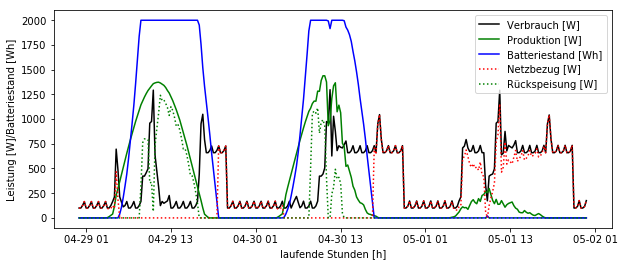

In [27]:
### es wird nur ein Ausschnitt betrachtet, nicht das gesamte Jahr
a  = int(105*24/deltaT)
e  = int(a+3*24/deltaT)
pPV      = hGlo[a:e] * PR  * pPVstc     # [W]
pVer     = pLoad[a:e]
tutcTeil = tutc[a:e]

# Initialisierung Array für Darstellung (***)
batStand      = np.zeros(tutcTeil.size) # Array für Batteriestand
netzbezug     = np.zeros(tutcTeil.size) # Array für Netzleistungsbezug
einspeisung   = np.zeros(tutcTeil.size) # Array für Einspeiseleistung

### Batterie Berechnung
wBez  = 0    # [kWh] Energie Netzbezug
wEin  = 0    # [kWh] Energie Netzeinspeisung   
wBat  = 0    # [kWh] Energie Batteriestand. Annahme das Batterie zu Beginn leer ist
for p in range(pPV.size):
    pBedarf = np.maximum(pVer[p]-pPV[p], 0)  # [W] 
    if wBat >= pBedarf*deltaT/1000:
        wBat = wBat - pBedarf*deltaT/1000    # [kWh]
        pBezug = 0                           # [kW] (***)
    else:
        wBez = wBez + pBedarf*deltaT/1000 - wBat   # [kWh]
        wBat  = 0
        pBezug = pBedarf - wBat*1000/deltaT   # [W] (***)
    pUebersch = np.maximum(pPV[p]-pVer[p], 0) # [W]      
    if wBat <= batCap:
        eNichtladbar = np.maximum(pUebersch*deltaT/1000 - (batCap-wBat),0) #[kWh]
        wBat = wBat + pUebersch*deltaT/1000 - eNichtladbar                 #[kWh] 
        wEin = wEin + eNichtladbar
        pEinspeisung = eNichtladbar/deltaT*1000  # [W] (***)
    else:
        wEin = wEin + pUebersch*deltaT/1000   # [kWh]
        pEinspeisung = pUebersch              # [W] (***)
    
    # Berechnete Werte ans Array übergeben (***)
    batStand[p]  = wBat*1000
    netzbezug[p] = pBezug        # [W]
    einspeisung[p] = pEinspeisung   # [W]
 
### Darstellung (***)
fig = plt.figure(6, figsize=(10,4))
plt.plot_date(tutcTeil, pVer,'k', label='Verbrauch [W]')
plt.plot_date(tutcTeil, pPV,'g', label='Produktion [W]')
plt.plot_date(tutcTeil, batStand,'b', label='Batteriestand [Wh]')
plt.plot_date(tutcTeil, netzbezug,'r:', label='Netzbezug [W]')
plt.plot_date(tutcTeil, einspeisung,'g:', label='Rückspeisung [W]')
plt.legend(loc='best')
plt.xlabel('laufende Stunden [h]')
plt.ylabel('Leistung [W]/Batteriestand [Wh]')
plt.show()

### Thermischer Speicher
Mit der selben Logik kann ein thermischer Speicher (Boiler) berechnet werden. Es wird von einer vollständigen Durchmischung im Speicher ausgegangen, keine Schichtung. D.h. der Energieinhalt berechnet sich über die Speichertemperatur tsp, Kaltwassertemperatur tkw, der Dichte $\rho$ und spezifischer Wärmekapazität von Wasser cp = 4.182 kJ/(kg K):

$W = vol \cdot \rho \cdot cp \cdot (tsp - tkw)$

Der Speicher hat folgendes Steuerverhalten: bei einer minimalen Speichertemperatur von tMin = 40 °C, wird der Heizstab über das Netz versorgt, sodass ausreichend Warmwasser erzeugt wird. Ist die Nachladung über das Netz aktiviert so bleibt diese aktiv bis der Speicher eine Temperatur von tMaxNetz = 45 °C hat (Hysteresis). Wird über PV geladen so ist die Ausschaltschwelle höher bei tMax     = 85 °C. Es kann so mehr Energie eingelagert werden. Zu berücksichtigen sind Speicherverluste von 23 W. 

In [28]:
### Thermische Speicher Berechnung
vol = 300 # [liter] Speicherinhalt
tkw      = 12 # [°C] Kaltwassertemperatur
tMin     = 40 # [°C] min. Speichertemp. Heizung ein
tMax     = 85 # [°C] max. Speichertemp. bei PV-Ladung
tMaxNetz = 45 # [°C] max. Speichertemp. bei Netz-Ladung
thermalLosses = 23 # [W] Speicherverluste 

tSp  = 45 # [°C] Sim.Starttemperatur Speicher       
wNetz = 0 # [kWh] Energie Netzbezug
netzLaden = False # Flag welches Netzladung anzeigt
tSpArray = np.zeros(zapf.size)   # [°C] Array für Speichertemperatur
pThermArray = np.zeros(zapf.size) # [W] Array Leistung Heizstab
pzapfArray = np.zeros(zapf.size) # [W] Array Zapf-Leistung     

for p in range(pPV.size):
    if tSp < tMax:
        pTherm = pPV[p] # [W]
    else:
        pTherm = 0 # [W]

    if tSp > tMaxNetz:
        netzLaden = False

    if tSp < tMin:
        netzLaden = True

    if netzLaden == True:
        wNetz = wNetz + pPVstc*deltaT # [kWh]
        pTherm = pPVstc*1000 + pTherm # [W]

    wSp   = vol * 4.182/3.6 * (tSp-tkw) # [Wh] Energieinhalt Speicher vorher
    pzapf = zapf[p]/deltaT * 4.182/3.6 * (tSp-tkw) # [W_therm] gezapfte Leistung
    wSp   = wSp + (pTherm - pzapf - thermalLosses)*deltaT  # [Wh] Energieinhalt Speicher nachher
    tSp = wSp/(vol*4.182/3.6) + tkw # [°C]  neue Speichertemperatur
    tSpArray[p] = tSp # [°C]
    pThermArray[p] = pTherm # [W]
    pzapfArray[p] = pzapf # [W]

Dieses Tutorial wurde mit Jupyter Notebook erstellt, welches ebenfalls in Anaconda-Paket enthalten ist. Markus Markstaler.